In [59]:
import pandas_datareader as pdr

Using my personal generated API KEY from the Tiingo Documentation.

In [60]:
# fetching the Apple stock details from the Tiingo API  using the datareader library
df = pdr.get_data_tiingo('AAPL', api_key='ac20fb375a917594a20e241bdd5cd75be2f9f032')

<ipython-input-60-bf5ab711ee58>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo('AAPL', api_key='ac20fb375a917594a20e241bdd5cd75be2f9f032')


In [61]:
# converting the fetched data into a readable tabular CSV file
df.to_csv('AAPL.csv')
df.head()

close    high     low    open    volume  \
symbol date                                                                  
AAPL   2019-03-14 00:00:00+00:00  183.73  184.10  182.56  183.90  23579508   
       2019-03-15 00:00:00+00:00  186.12  187.33  183.74  184.85  39042912   
       2019-03-18 00:00:00+00:00  188.02  188.39  185.79  185.80  26219832   
       2019-03-19 00:00:00+00:00  186.53  188.99  185.92  188.35  31646369   
       2019-03-20 00:00:00+00:00  188.16  189.49  184.73  186.23  31035231   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2019-03-14 00:00:00+00:00  44.217786  44.306833  43.936205  44.258699   
       2019-03-15 00:00:00+00:00  44.792981  45.084188  44.220193  44.487333   
       2019-03-18 00:00:00+00:00  45.250248  45.339295  44.713560  44.715967   
       2019-03-19 00:00:00+00:00  44.891654  45.483695  44.744847  45.329668   
       2019-03-20 00:00:00+00:00  45.283942  45.604029  44.458453  44.819454   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2019-03-14 00:00:00+00:00   94318032      0.0          1.0  
       2019-03-15 00:00:00+00:00  156171648      0.0          1.0  
       2019-03-18 00:00:00+00:00  104879328      0.0          1.0  
       2019-03-19 00:00:00+00:00  126585476      0.0          1.0  
       2019-03-20 00:00:00+00:00  124140924      0.0          1.0

In [62]:
import pandas as pd

In [63]:
df = pd.read_csv('AAPL.csv')

In [64]:
df1 = df.reset_index()['adjClose']

In [65]:
df1

0        44.217786
1        44.792981
2        45.250248
3        44.891654
4        45.283942
           ...    
1252    170.120000
1253    169.120000
1254    169.000000
1255    170.730000
1256    172.750000
Name: adjClose, Length: 1257, dtype: float64

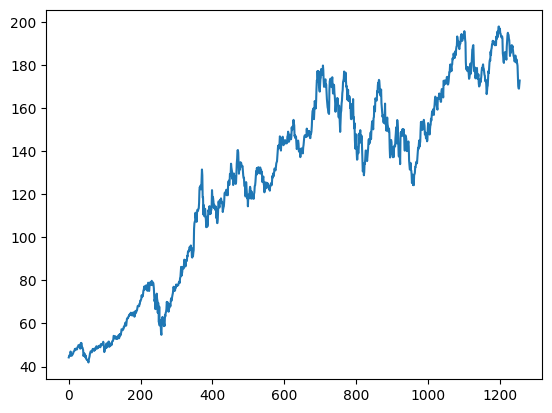

In [66]:
import matplotlib.pyplot as plt
plt.plot(df1)

Note: The LSTM algorithm is very sensitive to the scale of the data. Hence, we convert all of our adjusted closing values within a range of [0 , 1] using the MinMaxScaler, so that it gets very easy for the algorithm to function.

In [67]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
# By performing this step our df1 values will be converted between [0,1] and stored in an array

In [68]:
df1

array([[0.01504787],
       [0.0187353 ],
       [0.02166673],
       ...,
       [0.81499512],
       [0.82608571],
       [0.83903542]])

Now so far, we have have collected and cleaned our data according to our requirements. Now we will preprocess the data for training and testing.

It is very important that for algorithm like LSTM [where the current values are dependant on the previous one] , when we are planning to preprocess the dataset we have, we must divide it into two parts.

For eg:
Training Data => 70-80%.
Testing Data => remaining data.


In [69]:
# here we split the data into training and testing data.

training_size = int(len(df1)*0.70)
testing_size = len(df1) - training_size

train_data = df1[0:training_size]
test_data = df1[training_size:len(df1),:1]

Now here below, we start the data-preprocessing step. We simply convert the array of values into a dataset matrix.

For example:
df1 = [120, 130 ,132, 144, 158, 123] (array of values/features)

if we consider, timestamp = 3

output of [120, 130, 132] == 144,
similarly [130, 132, 144] == 158

So, the list of arrays is called x_train. And the list of corresponding output is called the y_train.

In [70]:
import numpy as np

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i : (i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [71]:
# reshaping into X = [t, t+1, t+2, t+3.... 100] and Y = 101
# for training data as well as testing data, considering time_step = 100.

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [72]:
print(X_train.shape), print(y_train.shape)

(778, 100)
(778,)


(None, None)

In [73]:
print(X_test.shape), print(ytest.shape)

(277, 100)
(277,)


(None, None)

Before applying the LSTM algorithm we need to reshape our X train into a three dimensional dataset. We already have two, we need one more. Eg, above (778, 100), 778 is the number of data, 100 is the timestep, we need one more value to convert it into a three-dimensional dataset.

In [74]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [75]:
# Here we create our Stacked LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout

In [76]:
model=Sequential()

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 100)          40800     
                                                                 
 dropout_3 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

This line trains the model using the training data X_train and y_train, validates it using the validation data X_test and ytest, runs for 100 epochs(iterations), uses a batch size of 64, and displays a progress bar during training.

In [78]:
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 17s 641ms/step - loss: 0.0672 - val_loss: 0.0346
Epoch 2/100
13/13 [==============================] - 8s 651ms/step - loss: 0.0099 - val_loss: 0.0395
Epoch 3/100
13/13 [==============================] - 7s 560ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 4/100
13/13 [==============================] - 8s 579ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 5/100
13/13 [==============================] - 8s 643ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/100
13/13 [==============================] - 8s 596ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 7/100
13/13 [==============================] - 8s 623ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/100
13/13 [==============================] - 8s 615ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 9/100
13/13 [==============================] - 6s 478ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 10/100
13/13 [==============================] - 8s 608ms/step - loss: 0.0027 - val_l

In [79]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [80]:
# Here we will do the prediction and check the performance of our model using both, our test data as well as the train data.

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 1s 99ms/step


In [81]:
# Transforming the values back to the original form because earlier we had scaled the values within the range [o,1]

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [82]:
# Calculating the Root Mean Square Error performance metrics (RMSE) for Training Data.

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

122.78158305542424

In [83]:
# Calculating the Root Mean Square Error performance metrics (RMSE) for Testing Data.
math.sqrt(mean_squared_error(ytest, test_predict))

174.54060269201847

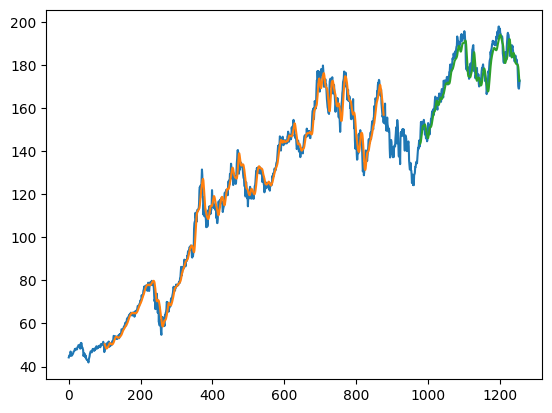

In [84]:
# PLOTTING THE GRAPH BASED ON ACTUAL VALUES, TRAINING PREDICTIONS & TESTING PREDICTIONS.

## shifting Training Predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

## shifting Testing Predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

## Plotting baseline and predictions all together.
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [85]:
len(test_data)

378

In [86]:
x_input = test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [87]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [88]:
## Prediction for the next 30 days.
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i+1,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.817897]
101
2 day output [[0.8138305]]
3 day output [[0.8117118]]
4 day output [[0.8106031]]
5 day output [[0.80996746]]
6 day output [[0.8095343]]
7 day output [[0.8091796]]
8 day output [[0.80884826]]
9 day output [[0.80851173]]
10 day output [[0.8081499]]
11 day output [[0.8077445]]
12 day output [[0.8072816]]
13 day output [[0.8067496]]
14 day output [[0.80614305]]
15 day output [[0.8054605]]
16 day output [[0.80470383]]
17 day output [[0.803879]]
18 day output [[0.8029941]]
19 day output [[0.80205804]]
20 day output [[0.801081]]
21 day output [[0.8000721]]
22 day output [[0.79904133]]
23 day output [[0.797997]]
24 day output [[0.7969468]]
25 day output [[0.79589736]]
26 day output [[0.7948546]]
27 day output [[0.79382294]]
28 day output [[0.7928058]]
29 day output [[0.7918066]]
30 day output [[0.7908267]]
[[0.8178970217704773], [0.8138304948806763], [0.8117117881774902], [0.8106030821800232], [0.8099674582481384], [0.8095343112945557], [0.8091796040534973], [0.8088482618331909]

In [89]:
# these are the 100 days we have from the test data
day_new = np.arange(1,101)

# these are the predicted days according to our model
day_pred = np.arange(101,131)

In [90]:
import matplotlib.pyplot as plt

In [91]:
len(df1)

1257

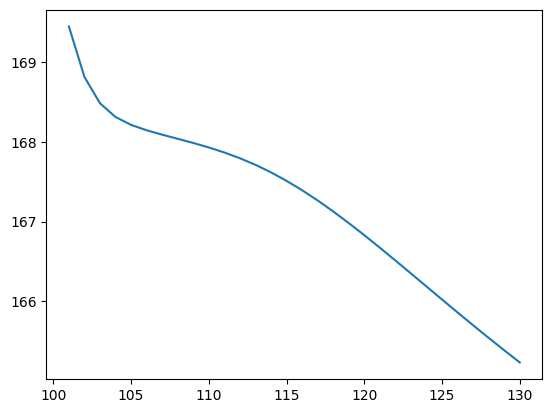

In [92]:
#plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

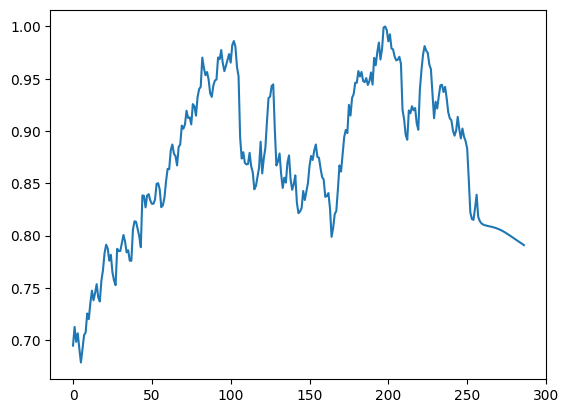

In [93]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])